# Exploring Object Fusion and Various Methods to Record Matching

## Installs and Imports

In [ ]:
# ## install dependencies
!pip install fuzzywuzzy
!pip install fuzzymatcher
!pip install metaphone
!pip install recordlinkage

In [ ]:
## import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# probabilistic modeling libraries
import fuzzywuzzy as fw
import fuzzymatcher as fm
import metaphone
from recordlinkage.preprocessing import clean, phonenumbers, value_occurence, phonetic
import recordlinkage as rl


%matplotlib inline

In [ ]:
## data imports
procComp_data = pd.read_csv('a__company.csv')
procGeo_data = pd.read_csv('a__geo.csv')
finComp_data = pd.read_csv('b__company.csv')
finHier_data = pd.read_csv('b__hierarchy.csv')
finLoc_data = pd.read_csv('b__address.csv')

In [ ]:
# check the status of the GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Procurement Data

### Company Data

#### 1. Pre-Processing and De-Duplication

In [ ]:
procComp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76344 entries, 0 to 76343
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   vendor_id         76344 non-null  int64  
 1   parent_vendor_id  7957 non-null   float64
 2   top_vendor_id     76312 non-null  float64
 3   cnt_children      76344 non-null  int64  
 4   orgtype_id        76344 non-null  int64  
 5   geo_id            76344 non-null  int64  
 6   name              76344 non-null  object 
 7   email             415 non-null    object 
 8   phone             6655 non-null   object 
 9   fax               0 non-null      float64
 10  dunsnumber        27685 non-null  float64
 11  websiteurl        6622 non-null   object 
 12  address           76344 non-null  object 
 13  address1          53217 non-null  object 
 14  address2          2071 non-null   object 
 15  country           76336 non-null  object 
 16  zipcode           75523 non-null  object

In [ ]:
## set index
procComp_data.index.name = 'PC_record'

In [ ]:
procComp_data.head()

,vendor_id,parent_vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,email,phone,fax,...,address1,address2,country,zipcode,parentdunsnumber,score,cnt_opp,bucket_id,load_date,lvl
PC_record,,,,,,,,,,,,,,,,,,,,,
0,26303872,NaN,26303872.0,0,0,100239,"LHASA, LLC [DUNS",NaN,NaN,NaN,...,NaN,NaN,US,0,NaN,0,0,16,2018-05-26,0.0
1,144388388,52137010.0,NaN,0,0,52450,"LAKE HAVASU, CITY OF",NaN,NaN,NaN,...,2330 MCCULLOCH BLVD N,NaN,US,86403,NaN,0,0,70,2018-05-26,NaN
2,143446948,NaN,143446948.0,0,0,100239,LONG LEWIS FORD,NaN,NaN,NaN,...,NaN,NaN,US,0,NaN,0,0,87,2018-05-26,0.0
3,21723402,NaN,21723402.0,0,0,49677,Lara Jean OConnor,NaN,NaN,NaN,...,6242 Kilmer Loop #204 Arvada,NaN,US,80403,NaN,0,0,9,2018-05-26,0.0
4,151786331,NaN,151786331.0,0,0,100239,LeChris,NaN,NaN,NaN,...,NaN,NaN,US,0,NaN,0,0,84,2018-05-26,0.0


In [ ]:
## view countries in data

procComp_data['country'].value_counts()

US    67733
AU     4923
CA     1434
GB      521
IN      203
      ...  
IO        1
EE        1
MM        1
GL        1
AL        1
Name: country, Length: 140, dtype: int64

In [ ]:
## filter out any foreign entities for this exercise

procComp_data_clean = procComp_data.loc[procComp_data['country'] == 'US']

In [ ]:
procComp_data_clean['country'].value_counts()

US    67733
Name: country, dtype: int64

In [ ]:
## filter out any vendors missing a phone number

procComp_data_clean.loc[procComp_data_clean['phone'].notnull()]

,vendor_id,parent_vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,email,phone,fax,...,address1,address2,country,zipcode,parentdunsnumber,score,cnt_opp,bucket_id,load_date,lvl
PC_record,,,,,,,,,,,,,,,,,,,,,
10,205992356,49856822.0,NaN,0,10168355,29715,"LAFAYETTE, CITY OF",NaN,7658071090,NaN,...,20 N 6TH ST STE 4,NaN,US,47901,NaN,0,0,29,2018-05-26,NaN
202,49961486,NaN,49961486.0,0,0,1081,List,procure@massmail.state.ma.us,617-988-6600,NaN,...,51 Sleeper Street,NaN,US,02210,NaN,0,0,89,2018-05-26,0.0
233,146183063,49846057.0,NaN,0,10168355,21869,"LEESBURG, CITY OF",NaN,3527289869,NaN,...,501 W MEADOW ST,NaN,US,34748,113889752.0,96,0,58,2018-05-26,NaN
237,52154362,NaN,52154362.0,2,10168355,26447,"LAKE SHORE CRYOTRONICS, INC.",NaN,6148912243,NaN,...,575 MCCORKLE BLVD,NaN,US,43082,51815553.0,91,0,23,2018-05-26,0.0
252,139919249,57284562.0,NaN,0,10168355,42472,"LINCOLN, CITY OF",NaN,4024418272,NaN,...,555 S 10TH ST,NaN,US,68508,51259786.0,86,0,46,2018-05-26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75644,156327921,NaN,156327921.0,0,10168355,56207,LONG ROAD TRAVEL SUPPLIES,NaN,510-540-4763,NaN,...,NaN,NaN,US,94708,783091515.0,20,0,1,2018-05-26,0.0
76018,145131466,NaN,145131466.0,0,10168355,12942,LUFBURROW & COMPANY INC,NaN,2403650550,NaN,...,1190 HARBOR TREE DR,NaN,US,21032,146593822.0,23,0,18,2018-05-26,0.0
76175,156303460,NaN,156303460.0,0,10168355,43782,LESTER R SCHMIDT,NaN,3184739124,NaN,...,1815 WHITE ST,NaN,US,71301,614674666.0,21,0,48,2018-05-26,0.0


In [ ]:
## set standard formatting for columns

# drop the final four digits of zipcode if in the 5-4 format
procComp_data_clean['zipcode'] = procComp_data_clean['zipcode'].str.split('-', expand=True)[0]

# drop the decimals from the identification numbers
id_nums = ['parent_vendor_id', 'top_vendor_id', 'lvl', 'parentdunsnumber']

for i in id_nums:
  procComp_data_clean[i] = procComp_data_clean[i].astype(str)
  procComp_data_clean[i] = procComp_data_clean[i].str.split('.', expand=True)[0]

In [ ]:
## check to see if the phone numbers are in a standard format or if some are incl. country code, etc

phone_lengths = procComp_data_clean.loc[procComp_data_clean['phone'].notnull()]

lengths = phone_lengths['phone'].str.len()
length_counts = lengths.value_counts()

In [ ]:
## check the count distribution of phone numbers

length_counts

10    5769
12     319
14     235
1       38
11      16
16      15
9       12
22      10
23       9
21       8
8        8
13       6
15       6
17       3
7        2
18       1
6        1
20       1
24       1
Name: phone, dtype: int64

In [ ]:
## view the value counts of phone number lengths

# Calculate proportions
numPhones = procComp_data_clean['phone'].notna().sum()
length_proportions = length_counts / numPhones
length_proportions = pd.DataFrame(length_proportions, index=length_proportions.index)
length_proportions['length'] = length_proportions.index
length_proportions.sort_values(by='length', inplace=True)

def plot_ratios(DataFrame, col1, col2, title, ylab, xlab):
  fig, ax = plt.subplots(1,1)
  ax.bar(DataFrame[col1], DataFrame[col2])
  ax.set_title(title)
  ax.set_ylabel(ylab)
  ax.set_yticks(np.arange(0, 1.01, 0.2))
  ax.set_xlabel(xlab)
  ax.set_xticklabels(DataFrame[col1], rotation=90)
plt.show()

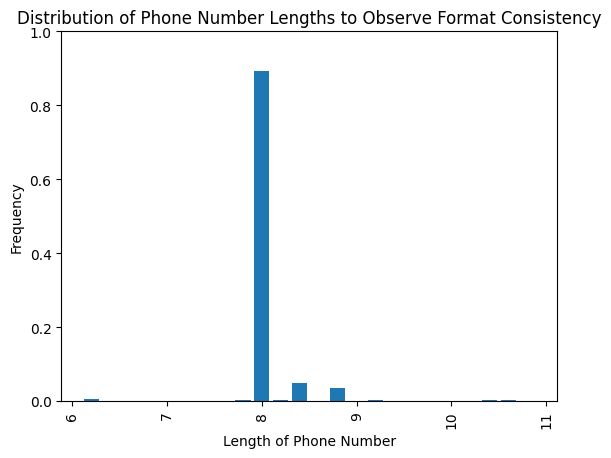

In [ ]:
plot_ratios(length_proportions, 'length', 'phone', 'Distribution of Phone Number Lengths to Observe Format Consistency',
            'Frequency', 'Length of Phone Number')

In [ ]:
length_proportions

,phone,length
1,0.005882,1
6,0.000155,6
7,0.000310,7
8,0.001238,8
9,0.001858,9
10,0.893034,10
11,0.002477,11
12,0.049381,12
13,0.000929,13
14,0.036378,14


In [ ]:
## create a function that extracts the area codes of phone numbers

def get_area_code(dataframe, column_name, new_df, new_col_name, new_col2, N):
  delimiters = ['-', '(', ')', ' ', '.']
  for i in delimiters:
    new_df[column_name] = new_df[column_name].str.replace(i, '')
    new_df[column_name] = new_df[column_name].str.split(r'x|ext', expand=True)[0]


  # function to extract the area code
  def phone_num(phone, N):
    phone = str(phone)
    if len(phone) >= N:
      phone = phone[-N:]
      area_code = phone[:3]
      rest_of_phone = phone[3:]
      # extract the area code
      return area_code, rest_of_phone
    else:
      return None, None

  # apply the phone_num function to extract the area code
  new_df[[new_col_name, new_col2]] = new_df[column_name].apply(lambda x: pd.Series(phone_num(x, N)))

  # new_df[new_col_name] = new_df[new_col_name][0:3]

  return new_df

In [ ]:
get_area_code(procComp_data_clean, 'phone', procComp_data_clean, 'area_code', 'rest_of_phone', 10)

,vendor_id,parent_vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,email,phone,fax,...,country,zipcode,parentdunsnumber,score,cnt_opp,bucket_id,load_date,lvl,area_code,rest_of_phone
PC_record,,,,,,,,,,,,,,,,,,,,,
0,26303872,nan,26303872,0,0,100239,"LHASA, LLC [DUNS",NaN,NaN,NaN,...,US,0,nan,0,0,16,2018-05-26,0,None,None
1,144388388,52137010,nan,0,0,52450,"LAKE HAVASU, CITY OF",NaN,NaN,NaN,...,US,86403,nan,0,0,70,2018-05-26,nan,None,None
2,143446948,nan,143446948,0,0,100239,LONG LEWIS FORD,NaN,NaN,NaN,...,US,0,nan,0,0,87,2018-05-26,0,None,None
3,21723402,nan,21723402,0,0,49677,Lara Jean OConnor,NaN,NaN,NaN,...,US,80403,nan,0,0,9,2018-05-26,0,None,None
4,151786331,nan,151786331,0,0,100239,LeChris,NaN,NaN,NaN,...,US,0,nan,0,0,84,2018-05-26,0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76339,156192761,nan,156192761,0,10168355,25381,LAWRENCE NELSON LIMITED LIABILITY COMPANY,NaN,NaN,NaN,...,US,40504,122551794,21,0,33,2018-05-26,0,None,None
76340,58905079,nan,58905079,0,0,34182,"Land O""Lakes",NaN,NaN,NaN,...,US,55112,nan,48,0,44,2018-05-26,0,None,None
76341,61041479,nan,61041479,0,0,100239,LEONARD W CATRON JR,NaN,NaN,NaN,...,US,0,nan,30,0,6,2018-05-26,0,None,None


In [ ]:
procComp_data_clean.loc[procComp_data_clean['phone'].notna()]

,vendor_id,parent_vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,email,phone,fax,...,country,zipcode,parentdunsnumber,score,cnt_opp,bucket_id,load_date,lvl,area_code,rest_of_phone
PC_record,,,,,,,,,,,,,,,,,,,,,
10,205992356,49856822,nan,0,10168355,29715,"LAFAYETTE, CITY OF",NaN,7658071090,NaN,...,US,47901,nan,0,0,29,2018-05-26,nan,765,8071090
202,49961486,nan,49961486,0,0,1081,List,procure@massmail.state.ma.us,6179886600,NaN,...,US,02210,nan,0,0,89,2018-05-26,0,617,9886600
233,146183063,49846057,nan,0,10168355,21869,"LEESBURG, CITY OF",NaN,3527289869,NaN,...,US,34748,113889752,96,0,58,2018-05-26,nan,352,7289869
237,52154362,nan,52154362,2,10168355,26447,"LAKE SHORE CRYOTRONICS, INC.",NaN,6148912243,NaN,...,US,43082,51815553,91,0,23,2018-05-26,0,614,8912243
252,139919249,57284562,nan,0,10168355,42472,"LINCOLN, CITY OF",NaN,4024418272,NaN,...,US,68508,51259786,86,0,46,2018-05-26,nan,402,4418272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75644,156327921,nan,156327921,0,10168355,56207,LONG ROAD TRAVEL SUPPLIES,NaN,5105404763,NaN,...,US,94708,783091515,20,0,1,2018-05-26,0,510,5404763
76018,145131466,nan,145131466,0,10168355,12942,LUFBURROW & COMPANY INC,NaN,2403650550,NaN,...,US,21032,146593822,23,0,18,2018-05-26,0,240,3650550
76175,156303460,nan,156303460,0,10168355,43782,LESTER R SCHMIDT,NaN,3184739124,NaN,...,US,71301,614674666,21,0,48,2018-05-26,0,318,4739124


In [ ]:
## verify the output of the function

lengths = procComp_data_clean['area_code'].str.len()
lengths.value_counts() # works!

3.0    6395
Name: area_code, dtype: int64

In [ ]:
## check if there are different formats in the date column

unique_values = procComp_data_clean['load_date'].unique()
unique_values

array(['2018-05-26', '2018-05-27', '2018-05-28', '2018-05-29'],
      dtype=object)

In [ ]:
procAddress_view = procComp_data_clean[['address', 'address1', 'address2', 'zipcode']]
procAddress_view.head()

## we'll drop address since address1 and address2 are just the address column broken up into street and city

,address,address1,address2,zipcode
PC_record,,,,
0,,NaN,NaN,0
1,2330 MCCULLOCH BLVD N,2330 MCCULLOCH BLVD N,NaN,86403
2,,NaN,NaN,0
3,6242 Kilmer Loop #204 Arvada,6242 Kilmer Loop #204 Arvada,NaN,80403
4,,NaN,NaN,0


In [ ]:
## clean the data and maintaing consistent formatting for each column

all_Comp_cols = list(procComp_data_clean.columns)
procComp_data_clean = procComp_data_clean[all_Comp_cols].astype(str)

# clean the procurement company data
for i in all_Comp_cols:
  if i != 'load_date':
    procComp_data_clean[i] = clean(procComp_data_clean[i], lowercase=True,
                             strip_accents='unicode')
  else:
    procComp_data_clean[i] = procComp_data_clean[i].str.replace('-', '')

In [ ]:
## view cleaned df

procComp_data_clean.head()

,vendor_id,parent_vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,email,phone,fax,...,country,zipcode,parentdunsnumber,score,cnt_opp,bucket_id,load_date,lvl,area_code,rest_of_phone
PC_record,,,,,,,,,,,,,,,,,,,,,
0,26303872,nan,26303872,0,0,100239,lhasa llc duns,nan,nan,nan,...,us,0,nan,0,0,16,20180526,0,none,none
1,144388388,52137010,nan,0,0,52450,lake havasu city of,nan,nan,nan,...,us,86403,nan,0,0,70,20180526,nan,none,none
2,143446948,nan,143446948,0,0,100239,long lewis ford,nan,nan,nan,...,us,0,nan,0,0,87,20180526,0,none,none
3,21723402,nan,21723402,0,0,49677,lara jean oconnor,nan,nan,nan,...,us,80403,nan,0,0,9,20180526,0,none,none
4,151786331,nan,151786331,0,0,100239,lechris,nan,nan,nan,...,us,0,nan,0,0,84,20180526,0,none,none


In [ ]:
## analyze the amount of null values in each column and the ratio of null to total rows

ratios = {}
all_Comp_cols = list(procComp_data_clean.columns)

for i in all_Comp_cols:
  missing = (procComp_data_clean[i] == '').sum() + (procComp_data_clean[i] == 'nan').sum()
  numRows = procComp_data_clean.shape[0]

  ratio = missing / numRows


  ratios[i] = ratio

ratios_df = pd.DataFrame.from_dict(ratios, orient='index', columns=['ratio']).sort_values(by='ratio', ascending=False)
ratios_df['column_name'] = ratios_df.index
ratios_df.reset_index(drop=True, inplace=True)

ratios_df

,ratio,column_name
0,1.000000,fax
1,0.993917,email
2,0.972524,address2
3,0.905689,websiteurl
4,0.905172,phone
5,0.888267,parent_vendor_id
6,0.636263,parentdunsnumber
7,0.610411,dunsnumber
8,0.302762,address1
9,0.297270,address


In [ ]:
# Plotting the barplot with the title defined above

def plot_ratios(DataFrame):
  fig, ax = plt.subplots(1,1)
  ax.bar(ratios_df['column_name'], ratios_df['ratio'])
  ax.set_title('Missing Value Ratios')
  ax.set_ylabel('Ratio')
  ax.set_yticks(np.arange(0, 1.01, 0.2))
  ax.set_xlabel('Column Name')
  ax.set_xticklabels(ratios_df['column_name'], rotation=90)
plt.show()

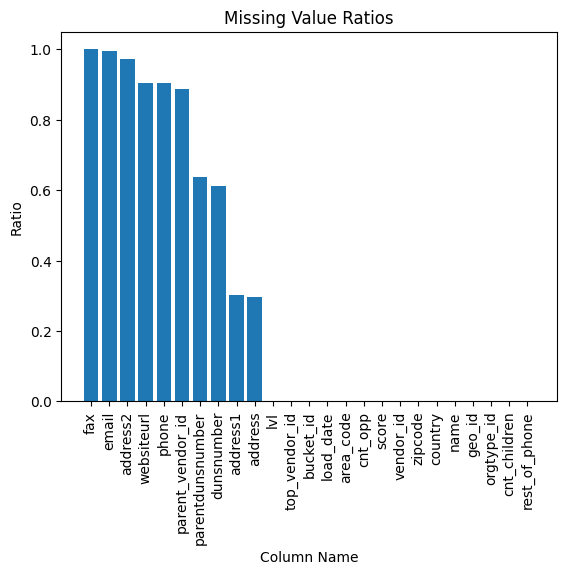

In [ ]:
plot_ratios(ratios_df)

Note: Since columns like fax, email, address2, websiteurl, phone, parentvendor_id,
and parentdunsnumber are missing majority of their values, I'll just go ahead and drop most of these + address since it contains mostly empty cells [set a flag for parent_vendor_id to indicate whether this company has a parent company]

In [ ]:
## convert parent_vendor_id, and dunsnumber to parent_vendor_flag, and dunsnumber_flag
# procComp_data_clean['parent_vendor_flag'] = procComp_data_clean['parent_vendor_id'].apply(lambda x: 1 if x != 'nan' else 0)
# procComp_data_clean['dunsnumber_flag'] = procComp_data_clean['dunsnumber'] .\
# apply(lambda x: 1 if x != 'nan' else 0)

## drop the columns missing majority of their values
procComp_data_clean.drop(['fax', 'email', 'address1', 'address2', 'websiteurl', 'phone',
                    'parentdunsnumber', 'parent_vendor_id', 'dunsnumber'],
                    axis=1, inplace=True)

In [ ]:
procComp_data_clean.head()

,vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,address,country,zipcode,score,cnt_opp,bucket_id,load_date,lvl,area_code,rest_of_phone
PC_record,,,,,,,,,,,,,,,,
0,26303872,26303872,0,0,100239,lhasa llc duns,,us,0,0,0,16,20180526,0,none,none
1,144388388,nan,0,0,52450,lake havasu city of,2330 mcculloch blvd n,us,86403,0,0,70,20180526,nan,none,none
2,143446948,143446948,0,0,100239,long lewis ford,,us,0,0,0,87,20180526,0,none,none
3,21723402,21723402,0,0,49677,lara jean oconnor,6242 kilmer loop 204 arvada,us,80403,0,0,9,20180526,0,none,none
4,151786331,151786331,0,0,100239,lechris,,us,0,0,0,84,20180526,0,none,none


In [ ]:
## check the format distributions of zipcodes

procComp_data_clean['zipcode'].str.len().value_counts()

5    47952
1    19472
4      294
3       13
2        2
Name: zipcode, dtype: int64

In [ ]:
procComp_data_clean = procComp_data_clean.loc[procComp_data_clean['zipcode'].str.len() > 3]

In [ ]:
procComp_data_clean.loc[procComp_data_clean['zipcode'].str.len() == 4]

,vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,address,country,zipcode,score,cnt_opp,bucket_id,load_date,lvl,area_code,rest_of_phone
PC_record,,,,,,,,,,,,,,,,
197,298375828,298375828,0,0,0,liquid air,,us,2165,0,0,23,20180526,0,none,none
623,298088475,298088475,0,0,1040,leaders international pty ltd,po box 6810,us,2153,0,0,88,20180526,0,none,none
1122,298317273,298317273,0,0,0,lismore rsl,1 market street,us,2480,0,0,83,20180526,0,none,none
1160,298254183,298254183,0,0,1101,lake macquarie council,po box1906,us,2284,0,0,77,20180526,0,none,none
1230,298326657,298326657,0,0,1960,lavender racing developments,90 heal street,us,4005,0,0,21,20180526,0,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68237,312962298,312962298,0,10168355,1171,la santaniana sa,avenida republica argentina 974,us,2420,53,0,33,20180526,0,none,none
68342,146825102,146825102,0,0,1400,lorax energy systems llc,,us,2807,25,0,91,20180526,0,none,none
69036,296322944,296322944,0,0,2445,longreach shire council,po box 472,us,4730,23,0,5,20180526,0,none,none


In [ ]:
## test out adding leading zeros to zipcodes

procComp_zeros_test = procComp_data_clean['zipcode']

In [ ]:
procComp_zeros_test = pd.DataFrame(procComp_zeros_test)

In [ ]:
## add leading zeros to 'ID' column

procComp_zeros_test['zipcode2'] = procComp_zeros_test['zipcode'].apply('{:0>5}'.format)

In [ ]:
procComp_zeros_test.loc[procComp_zeros_test['zipcode'].str.len() < 5]

,zipcode,zipcode2
PC_record,,
197,2165,02165
623,2153,02153
1122,2480,02480
1160,2284,02284
1230,4005,04005
...,...,...
68237,2420,02420
68342,2807,02807
69036,4730,04730


In [ ]:
## lets look at the lengths of vendor ids, and geo_ids

# procComp_data_clean['vendor_id'].str.len().value_counts()    # 9 is the largest str len
procComp_data_clean['geo_id'].str.len().value_counts()        # 5 is the largest str len

5    41107
4     5472
3     1099
1      542
2       26
Name: geo_id, dtype: int64

In [ ]:
procComp_data_clean['top_vendor_id'].str.len().value_counts()

8    30439
9    17775
3       32
Name: top_vendor_id, dtype: int64

In [ ]:
procComp_data_clean = procComp_data_clean.loc[procComp_data_clean['top_vendor_id'] != 'nan']

In [ ]:
## orgtype_id

procComp_data_clean['orgtype_id'].str.len().value_counts()  #longest is 8

1    26018
8    22196
Name: orgtype_id, dtype: int64

In [ ]:
## standardize the lengths of these columns

procComp_data_clean['vendor_id'] = procComp_data_clean['vendor_id'].apply('{:0>9}'.format)
procComp_data_clean['geo_id'] = procComp_data_clean['geo_id'].apply('{:0>6}'.format)  ## longest str len for geo id is 6 on the geo df
procComp_data_clean['zipcode'] = procComp_data_clean['zipcode'].apply('{:0>5}'.format)
procComp_data_clean['top_vendor_id'] = procComp_data_clean['top_vendor_id'].apply('{:0>9}'.format)
procComp_data_clean['cnt_children'] = procComp_data_clean['cnt_children'].apply('{:0>3}'.format)


In [ ]:
procComp_data_clean.loc[procComp_data_clean['area_code'] != 'none']

,vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,address,country,zipcode,score,cnt_opp,bucket_id,load_date,lvl,area_code,rest_of_phone
PC_record,,,,,,,,,,,,,,,,
202,049961486,049961486,000,0,001081,list,51 sleeper street,us,02210,0,0,89,20180526,0,617,9886600
237,052154362,052154362,002,10168355,026447,lake shore cryotronics inc,575 mccorkle blvd,us,43082,91,0,23,20180526,0,614,8912243
279,156272064,156272064,000,10168355,053988,los angeles municipal services,537 w 9th st,us,90731,58,0,50,20180526,0,310,5221404
311,052171002,052171002,000,10168355,020481,leo porter,752 bayside dr a503,us,32920,66,0,50,20180526,0,443,4144623
583,063211999,063211999,000,10168355,018019,lynns imports exotic gardens inc,1230 red bank rd unit 11,us,29445,0,0,59,20180526,0,843,5723089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75644,156327921,156327921,000,10168355,056207,long road travel supplies,,us,94708,20,0,1,20180526,0,510,5404763
76018,145131466,145131466,000,10168355,012942,lufburrow company inc,1190 harbor tree dr,us,21032,23,0,18,20180526,0,240,3650550
76175,156303460,156303460,000,10168355,043782,lester r schmidt,1815 white st,us,71301,21,0,48,20180526,0,318,4739124


#### De-Duplicate the Set

In [ ]:
indexer = rl.Index()
indexer.block('vendor_id')
candidate_links = indexer.index(procComp_data_clean)
len(candidate_links)

0

Note: Since we have a unique identifier in Vendor Id and there are no potential duplicates we can move on to Procurement Geo data.

### Location Data

#### 1. Pre-Processing and De-Duplication

In [ ]:
procGeo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14480 entries, 0 to 14479
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   geo_id              14480 non-null  int64  
 1   zipcode             14344 non-null  object 
 2   is_primary          14480 non-null  object 
 3   latitude            14215 non-null  object 
 4   longitude           14215 non-null  object 
 5   elevation           14206 non-null  float64
 6   state               14344 non-null  object 
 7   state_full_name     14337 non-null  object 
 8   area_code           14215 non-null  object 
 9   city                14344 non-null  object 
 10  city_display        14215 non-null  object 
 11  county              14208 non-null  object 
 12  county_fips         12994 non-null  object 
 13  state_fips          14208 non-null  object 
 14  timezone            13001 non-null  float64
 15  daylight_saving     14215 non-null  object 
 16  regi

In [ ]:
## set index

procGeo_data.index.name = 'PG_record'

In [ ]:
procGeo_data.head()

,geo_id,zipcode,is_primary,latitude,longitude,elevation,state,state_full_name,area_code,city,...,state_fips,timezone,daylight_saving,region,division,congress_district,congress_land_area,country,continent,country_iso2
PG_record,,,,,,,,,,,,,,,,,,,,,
0,8278,14467,t,43.043294,-77.614181,513.0,NY,New York,585,HENRIETTA,...,36,5.0,Y,Northeast,Middle Atlantic,25|27,510.19|3973.13,USA,North America,US
1,3430,6258,t,41.8975,-71.9631,287.0,CT,Connecticut,860,POMFRET,...,09,5.0,Y,Northeast,New England,02,1987.68,USA,North America,US
2,48308,78234,t,29.462264,-98.4414,675.0,TX,Texas,210,SAN ANTONIO,...,48,6.0,Y,South,West South Central,21,5920.89,USA,North America,US
3,382713,E2K1K7,t,45.276163,-66.080195,57.0,New Brunswick / Nouveau-Brunswick,New Brunswick / Nouveau-Brunswick,CA-NB,Saint John,...,CA04,NaN,-03:00,NaN,NaN,NaN,NaN,CAN,North America,CA
4,8165,14213,t,42.916747,-78.892782,583.0,NY,New York,716,BUFFALO,...,36,5.0,Y,Northeast,Middle Atlantic,26,219.13,USA,North America,US


In [ ]:
## also filter out to only the U.S

procGeo_data = procGeo_data.loc[procGeo_data['country_iso2'] == 'US']

In [ ]:
procGeo_view = procGeo_data[['city', 'city_display', 'county', 'county_fips']]
procGeo_view.loc[procGeo_view['city'] != procGeo_view['city_display']]

## this may change once we have standard formats for the string variables

,city,city_display,county,county_fips
PG_record,,,,
0,HENRIETTA,Henrietta,MONROE,055
1,POMFRET,Pomfret,WINDHAM,015
2,SAN ANTONIO,San Antonio,BEXAR,029
4,BUFFALO,Buffalo,ERIE,029
5,ZOLFO SPRINGS,Zolfo Springs,HARDEE,049
...,...,...,...,...
14474,RICHARDSON,Richardson,DALLAS,113
14475,SPRINGFIELD,Springfield,FAIRFAX,059
14476,JEFFERSON CITY,Jefferson City,COLE,051


In [ ]:
procGeo_data['longitude'].str.len().value_counts()

10.0    8376
11.0    2578
9.0     1347
8.0      659
7.0       15
6.0       14
1.0       10
5.0        2
Name: longitude, dtype: int64

In [ ]:
procGeo_data['latitude'].str.len().value_counts()

9.0     10573
8.0      1524
7.0       856
6.0        30
1.0        10
5.0         4
4.0         3
11.0        1
Name: latitude, dtype: int64

In [ ]:
## set standard formatting for specific columns

# we can set all columns to a string type in this df
procGeo_data_clean = procGeo_data.astype(str)

procGeo_data_clean['is_primary'] = procGeo_data_clean['is_primary'] .\
                              apply(lambda x: 1 if x == 't' else 0)
procGeo_data_clean['zipcode'] = procGeo_data_clean['zipcode'].apply('{:0>5}' .\
                                                                    format)
procGeo_data_clean['geo_id'] = procGeo_data_clean['geo_id'].apply('{:0>6}'  .\
                                                                  format)

In [ ]:
procGeo_data_clean['geo_id'].str.len().value_counts()

6    13002
Name: geo_id, dtype: int64

In [ ]:
## expand the area code column into three diff columns to hold individual area codes

def clean_geo_area_code(dataframe, col1, newcol1, newcol2, newcol3):
  dataframe[newcol1] = dataframe[col1].str.split('/', expand=True)[0]
  dataframe[newcol2] = dataframe[col1].str.split('/', expand=True)[1]
  dataframe[newcol3] = dataframe[col1].str.split('/', expand=True)[2]

  return dataframe

In [ ]:
clean_geo_area_code(procGeo_data_clean, 'area_code', 'area_code_1',
                    'area_code_2', 'area_code_3')

,geo_id,zipcode,is_primary,latitude,longitude,elevation,state,state_full_name,area_code,city,...,region,division,congress_district,congress_land_area,country,continent,country_iso2,area_code_1,area_code_2,area_code_3
PG_record,,,,,,,,,,,,,,,,,,,,,
0,008278,14467,1,43.043294,-77.614181,513.0,NY,New York,585,HENRIETTA,...,Northeast,Middle Atlantic,25|27,510.19|3973.13,USA,North America,US,585,None,None
1,003430,06258,1,41.8975,-71.9631,287.0,CT,Connecticut,860,POMFRET,...,Northeast,New England,02,1987.68,USA,North America,US,860,None,None
2,048308,78234,1,29.462264,-98.4414,675.0,TX,Texas,210,SAN ANTONIO,...,South,West South Central,21,5920.89,USA,North America,US,210,None,None
4,008165,14213,1,42.916747,-78.892782,583.0,NY,New York,716,BUFFALO,...,Northeast,Middle Atlantic,26,219.13,USA,North America,US,716,None,None
5,021421,33890,1,27.486423,-81.708558,109.0,FL,Florida,863,ZOLFO SPRINGS,...,South,South Atlantic,17,6369.97,USA,North America,US,863,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14474,046063,75080,1,32.967704,-96.73876,463.0,TX,Texas,972/214/469,RICHARDSON,...,South,West South Central,03|32,480.88|185.66,USA,North America,US,972,214,469
14475,013547,22151,1,38.801644,-77.210894,447.0,VA,Virginia,703,SPRINGFIELD,...,South,South Atlantic,08|11,149.24|185.09,USA,North America,US,703,None,None
14476,040745,65109,1,38.55815,-92.283092,555.0,MO,Missouri,573,JEFFERSON CITY,...,Midwest,West North Central,03,6851.54,USA,North America,US,573,None,None


In [ ]:
procGeo_data_clean.head(3)

,geo_id,zipcode,is_primary,latitude,longitude,elevation,state,state_full_name,area_code,city,...,region,division,congress_district,congress_land_area,country,continent,country_iso2,area_code_1,area_code_2,area_code_3
PG_record,,,,,,,,,,,,,,,,,,,,,
0,008278,14467,1,43.043294,-77.614181,513.0,NY,New York,585,HENRIETTA,...,Northeast,Middle Atlantic,25|27,510.19|3973.13,USA,North America,US,585,None,None
1,003430,06258,1,41.8975,-71.9631,287.0,CT,Connecticut,860,POMFRET,...,Northeast,New England,02,1987.68,USA,North America,US,860,None,None
2,048308,78234,1,29.462264,-98.4414,675.0,TX,Texas,210,SAN ANTONIO,...,South,West South Central,21,5920.89,USA,North America,US,210,None,None


In [ ]:
procGeo_data_clean.loc[procGeo_data_clean['area_code'].str.len() > 3]

,geo_id,zipcode,is_primary,latitude,longitude,elevation,state,state_full_name,area_code,city,...,region,division,congress_district,congress_land_area,country,continent,country_iso2,area_code_1,area_code_2,area_code_3
PG_record,,,,,,,,,,,,,,,,,,,,,
15,012952,21043,1,39.256902,-76.791739,233.0,MD,Maryland,410/301/443,ELLICOTT CITY,...,South,South Atlantic,02|03|07,348.88|304.14|488.03,USA,North America,US,410,301,443
17,026421,43062,1,40.000678,-82.676977,829.0,OH,Ohio,740/614,PATASKALA,...,Midwest,East North Central,03|12|15,228|2271.91|4738.93,USA,North America,US,740,614,None
25,052021,85303,1,33.530804,-112.219974,1082.0,AZ,Arizona,623/602,GLENDALE,...,West,Mountain,07|08,205.12|539.66,USA,North America,US,623,602,None
30,055803,94028,1,37.36888,-122.214268,15.0,CA,California,650/415,PORTOLA VALLEY,...,West,Pacific,18,696.12,USA,North America,US,650,415,None
36,033735,54615,1,44.246822,-90.77217,796.0,WI,Wisconsin,715/608,BLACK RIVER FALLS,...,Midwest,East North Central,03,11111.79,USA,North America,US,715,608,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14444,046203,75243,1,32.913819,-96.733495,463.0,TX,Texas,214/972/469,DALLAS,...,South,West South Central,05|32,5043.85|185.66,USA,North America,US,214,972,469
14453,004744,08540,1,40.378246,-74.662206,54.0,NJ,New Jersey,609/732/908,PRINCETON,...,Northeast,Middle Atlantic,07|12,970.19|412.23,USA,North America,US,609,732,908
14462,018763,30309,1,33.798463,-84.388284,1050.0,GA,Georgia,404/678/770,ATLANTA,...,South,South Atlantic,05,264.91,USA,North America,US,404,678,770


Note: Since we have multiple area codes matched to some cities, we can set a threshold for the similarity measures we use in the algorithm to help determine if we have a match

In [ ]:
## clean the data and maintaing consistent formatting for each column

all_Geo_cols = list(procGeo_data_clean.columns)
procGeo_data_clean = procGeo_data_clean[all_Geo_cols].astype(str)

# clean the procurement location data
for i in all_Geo_cols:
  if i != ['area_code']:
    procGeo_data_clean[i] = clean(procGeo_data_clean[i], lowercase=True,
                                  strip_accents='unicode')

In [ ]:
procGeo_data_clean.head()

,geo_id,zipcode,is_primary,latitude,longitude,elevation,state,state_full_name,area_code,city,...,region,division,congress_district,congress_land_area,country,continent,country_iso2,area_code_1,area_code_2,area_code_3
PG_record,,,,,,,,,,,,,,,,,,,,,
0,008278,14467,1,43043294,77614181,5130,ny,new york,585,henrietta,...,northeast,middle atlantic,2527,51019397313,usa,north america,us,585,none,none
1,003430,06258,1,418975,719631,2870,ct,connecticut,860,pomfret,...,northeast,new england,02,198768,usa,north america,us,860,none,none
2,048308,78234,1,29462264,984414,6750,tx,texas,210,san antonio,...,south,west south central,21,592089,usa,north america,us,210,none,none
4,008165,14213,1,42916747,78892782,5830,ny,new york,716,buffalo,...,northeast,middle atlantic,26,21913,usa,north america,us,716,none,none
5,021421,33890,1,27486423,81708558,1090,fl,florida,863,zolfo springs,...,south,south atlantic,17,636997,usa,north america,us,863,none,none


In [ ]:
## analyze amount of null values in each column and ratio of null to total rows

ratios = {}
all_Geo_cols = list(procGeo_data_clean.columns)

for i in all_Geo_cols:
  missing = (procGeo_data_clean[i] == '').sum() + (procGeo_data_clean[i] == 'nan').sum()
  numRows = procGeo_data_clean.shape[0]

  ratio = missing / numRows

  ratios[i] = ratio

ratios_df = pd.DataFrame.from_dict(ratios, orient='index', columns=['ratio']) .\
                                    sort_values(by='ratio', ascending=False)
ratios_df['column_name'] = ratios_df.index
ratios_df.reset_index(drop=True, inplace=True)

ratios_df

,ratio,column_name
0,0.044685,congress_land_area
1,0.044685,congress_district
2,0.007691,division
3,0.007691,region
4,0.000615,state_fips
5,0.000615,county
6,0.000615,state_full_name
7,0.000615,county_fips
8,0.000077,daylight_saving
9,0.000077,timezone


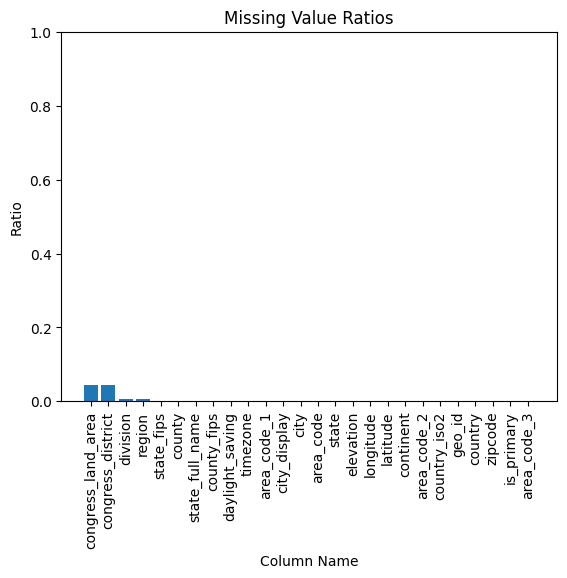

In [ ]:
plot_ratios(ratios_df)

In [ ]:
procGeo_data_clean.drop(['congress_land_area', 'congress_district',
                         'latitude', 'longitude', 'state_full_name',
                         'elevation','area_code'], axis=1, inplace=True)

In [ ]:
procGeo_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13002 entries, 0 to 14478
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   geo_id           13002 non-null  object
 1   zipcode          13002 non-null  object
 2   is_primary       13002 non-null  object
 3   state            13002 non-null  object
 4   city             13002 non-null  object
 5   city_display     13002 non-null  object
 6   county           13002 non-null  object
 7   county_fips      13002 non-null  object
 8   state_fips       13002 non-null  object
 9   timezone         13002 non-null  object
 10  daylight_saving  13002 non-null  object
 11  region           13002 non-null  object
 12  division         13002 non-null  object
 13  country          13002 non-null  object
 14  continent        13002 non-null  object
 15  country_iso2     13002 non-null  object
 16  area_code_1      13002 non-null  object
 17  area_code_2      13002 non-null

#### De-Duplicate the Set

In [ ]:
indexer = rl.Index()
indexer.block('geo_id')
candidate_links = indexer.index(procGeo_data_clean)
len(candidate_links)

0

Note: there are no potential duplicates found by the blocking algorithm move forward with the linkage

### Link the Procurement Data Sets

In [ ]:
procComp_data_clean.info()
procGeo_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48214 entries, 3 to 76340
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   vendor_id      48214 non-null  object
 1   top_vendor_id  48214 non-null  object
 2   cnt_children   48214 non-null  object
 3   orgtype_id     48214 non-null  object
 4   geo_id         48214 non-null  object
 5   name           48214 non-null  object
 6   address        48214 non-null  object
 7   country        48214 non-null  object
 8   zipcode        48214 non-null  object
 9   score          48214 non-null  object
 10  cnt_opp        48214 non-null  object
 11  bucket_id      48214 non-null  object
 12  load_date      48214 non-null  object
 13  lvl            48214 non-null  object
 14  area_code      48214 non-null  object
 15  rest_of_phone  48214 non-null  object
dtypes: object(16)
memory usage: 7.3+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13002 entries, 0 to 14478


In [ ]:
indexer = rl.Index()
indexer.block(left_on='geo_id', right_on='geo_id')
candidate_links = indexer.index(procGeo_data_clean, procComp_data_clean)
len(candidate_links)

48214

In [ ]:
## make the comparisons

compare_cl = rl.Compare()



#initialize similarity measurement algorithms
compare_cl.exact(left_on = 'geo_id', right_on='geo_id', label='geo_id')
compare_cl.exact(left_on='area_code_1', right_on='area_code', label='area_code1')
compare_cl.exact(left_on='zipcode', right_on='zipcode', label='zipcode')
features = compare_cl.compute(candidate_links, procGeo_data_clean, procComp_data_clean)

In [ ]:
features.sum(axis=1).value_counts().sort_index(ascending=False)

3     5047
2    42633
1      534
dtype: int64

In [ ]:
features

geo_id  area_code1  zipcode
PG_record PC_record                             
0         46543           1           1        1
1         933             1           0        1
          6480            1           0        1
          17887           1           0        1
          20035           1           0        1
...                     ...         ...      ...
14477     25150           1           0        1
          35561           1           0        1
14478     3066            1           0        1
          46996           1           0        1
          70703           1           0        1

[48214 rows x 3 columns]

In [ ]:
potential_matches = features[features.sum(axis=1) > 2].reset_index()
potential_matches['Score'] = potential_matches.loc[:, 'geo_id':'zipcode'] .\
                                                                sum(axis=1)

In [ ]:
potential_matches

,PG_record,PC_record,geo_id,area_code1,zipcode,Score
0,0,46543,1,1,1,3
1,8,42615,1,1,1,3
2,14,34275,1,1,1,3
3,14,41411,1,1,1,3
4,15,33173,1,1,1,3
...,...,...,...,...,...,...
5042,14467,63735,1,1,1,3
5043,14474,31546,1,1,1,3
5044,14474,32089,1,1,1,3
5045,14475,44481,1,1,1,3


In [ ]:
## merge the data together

procurementDf = potential_matches

# make sub dfs for the columns we want to include
pcMerge = procComp_data_clean
pcMerge = pcMerge.drop(['top_vendor_id', 'cnt_children', 'orgtype_id',
                        'score', 'cnt_opp', 'bucket_id', 'load_date',
                        'lvl'], axis=1)

pgMerge = procGeo_data_clean
pgMerge = pgMerge.drop(['geo_id', 'zipcode', 'is_primary', 'county_fips',
                        'state_fips', 'timezone', 'daylight_saving',
                        'region', 'division', 'country', 'continent',
                        'area_code_1', 'area_code_2', 'area_code_3'], axis=1)

In [ ]:
procurementDf = potential_matches.merge(pcMerge, on='PC_record', how='inner')

In [ ]:
procurementDf = procurementDf.merge(pgMerge, on='PG_record', how='inner')

In [ ]:
procurementDf.columns

Index(['PG_record', 'PC_record', 'geo_id_x', 'area_code1', 'zipcode_x',
       'Score', 'vendor_id', 'geo_id_y', 'name', 'address', 'country',
       'zipcode_y', 'area_code', 'rest_of_phone', 'state', 'city',
       'city_display', 'county', 'country_iso2'],
      dtype='object')

In [ ]:
procurementDf = procurementDf.drop(['PG_record', 'PC_record', 'geo_id_x',
                                    'area_code1', 'zipcode_x', 'Score',
                                    'country_iso2'], axis=1)
procurementDf.index.name = 'pRecord'

### Final Procurement Dataframe

In [ ]:
procurementDf.head(3)

,vendor_id,geo_id_y,name,address,country,zipcode_y,area_code,rest_of_phone,state,city,city_display,county
pRecord,,,,,,,,,,,,
0,285924451,008278,lake image systems inc,205 summit point dr 2,us,14467,585,3213630,ny,henrietta,henrietta,monroe
1,173865819,010736,lafayette college,200 high st,us,18042,610,3305070,pa,easton,easton,northampton
2,052135625,011807,laurel bridge software inc,160 e main street,us,19711,302,4538947,de,newark,newark,new castle


In [ ]:
procComp_data_clean.loc[procComp_data_clean['vendor_id'] == '285924451']

,vendor_id,top_vendor_id,cnt_children,orgtype_id,geo_id,name,address,country,zipcode,score,cnt_opp,bucket_id,load_date,lvl,area_code,rest_of_phone
PC_record,,,,,,,,,,,,,,,,
46543,285924451,285924451,000,10168355,008278,lake image systems inc,205 summit point dr 2,us,14467,71,0,87,20180526,0,585,3213630


In [ ]:
procGeo_data_clean.loc[procGeo_data_clean['geo_id'] == '008278']

,geo_id,zipcode,is_primary,state,city,city_display,county,county_fips,state_fips,timezone,daylight_saving,region,division,country,continent,country_iso2,area_code_1,area_code_2,area_code_3
PG_record,,,,,,,,,,,,,,,,,,,
0,008278,14467,1,ny,henrietta,henrietta,monroe,055,36,50,y,northeast,middle atlantic,usa,north america,us,585,none,none


Looks good! Let's move on.

## Finance Data

### Company Data

In [ ]:
finComp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196498 entries, 0 to 196497
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   b_entity_id         196498 non-null  object 
 1   entity_name         196498 non-null  object 
 2   entity_proper_name  196498 non-null  object 
 3   primary_sic_code    95243 non-null   float64
 4   industry_code       96094 non-null   float64
 5   sector_code         96094 non-null   float64
 6   iso_country         193241 non-null  object 
 7   metro_area          75388 non-null   object 
 8   state_province      109294 non-null  object 
 9   zip_postal_code     69297 non-null   object 
 10  web_site            50811 non-null   object 
 11  entity_type         193126 non-null  object 
 12  entity_sub_type     81142 non-null   object 
 13  year_founded        14954 non-null   float64
 14  iso_country_incorp  193241 non-null  object 
 15  iso_country_cor     13837 non-null

In [ ]:
## set index

finComp_data.index.name = 'FC_record'

In [ ]:
finComp_data

,b_entity_id,entity_name,entity_proper_name,primary_sic_code,industry_code,sector_code,iso_country,metro_area,state_province,zip_postal_code,web_site,entity_type,entity_sub_type,year_founded,iso_country_incorp,iso_country_cor,nace_code
FC_record,,,,,,,,,,,,,,,,,
0,000BFG-E,LOTSOFF CORP,LOT$OFF Corp.,5331.0,3520.0,3500.0,US,San Antonio/TX Metro,TX,78209-4859,NaN,PVT,CP,1975.0,US,US,47.19
1,000P08-E,LASERSCOPE INC,"Laserscope, Inc.",3845.0,2325.0,2300.0,US,San Francisco/CA Metro,CA,95134-2011,http://www.laserscope.com,SUB,CP,1982.0,US,IE,26.60
2,000JF6-E,LONGWEN GROUP CORP,Longwen Group Corp.,6799.0,3320.0,3300.0,US,Phoenix/AZ Metro,AZ,85258,NaN,PUB,CP,1980.0,US,US,64.99
3,000L15-E,LISI SA,LISI SA,3728.0,1330.0,1300.0,FR,Lyon/France Metro,FC,90000,http://www.lisi-group.com,PUB,CP,1968.0,FR,FR,30.30
4,000NY7-E,LA GEAR INC,"L.A. Gear, Inc.",5139.0,3255.0,3250.0,US,Los Angeles/CA Metro,CA,90049,http://www.lagear.com,SUB,CP,1979.0,US,US,46.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196493,0HPQJD-E,LK ANLAEG V LARS KIRSCHNER,L.K. Anlæg V/lars Kirschner,NaN,NaN,NaN,DK,NaN,CR,NaN,http://www.lkanlaeg.com,PVT,NaN,NaN,DK,NaN,NaN
196494,0HPQKB-E,L&O FINSEN EJENDOMME APS,L&O Finsen Ejendomme ApS,NaN,NaN,NaN,DK,NaN,CR,NaN,NaN,PVT,NaN,NaN,DK,NaN,NaN
196495,0HPQKQ-E,L KEPPEL PALMER DECEASED 1,L Keppel-Palmer Deceased 1,6733.0,6010.0,6000.0,GB,NaN,EX,NaN,NaN,TRU,NaN,NaN,GB,NaN,64.30


In [ ]:
## get the max string length of each of the columns in the dataframe

# finComp_all_cols = list(finComp_data.columns)
# for col in finComp_all_cols:
#     print(col, len(finComp_data[col].astype(str).max()))

In [ ]:
## let's filter this df again to only have US based entities

finComp_data = finComp_data[finComp_data['iso_country'] == 'US']

In [ ]:
## preliminary standardization

# convert zipcode to 5 digits format
# drop the final four digits of zipcode if in the 5-4 format
finComp_data['zip_postal_code'] = finComp_data['zip_postal_code'] .\
                                  str.split('-',expand=True)[0]

In [ ]:
## analyze the amount of null values in each column and the ratio of null to total rows

ratios = {}
finComp_all_cols = list(finComp_data.columns)

for i in finComp_all_cols:
  missing = (finComp_data[i] == '').sum() + (finComp_data[i] == 'NaN') .\
                                sum() + (finComp_data[i].isna()).sum()
  numRows = finComp_data.shape[0]

  ratio = missing / numRows

  ratios[i] = ratio

ratios_df = pd.DataFrame.from_dict(ratios, orient='index', columns=['ratio']) .\
                                      sort_values(by='ratio', ascending=False)
ratios_df['column_name'] = ratios_df.index
ratios_df.reset_index(drop=True, inplace=True)

ratios_df

,ratio,column_name
0,0.904843,iso_country_cor
1,0.891802,year_founded
2,0.701843,web_site
3,0.618547,metro_area
4,0.596300,zip_postal_code
5,0.585471,entity_sub_type
6,0.384728,primary_sic_code
7,0.383739,nace_code
8,0.383621,industry_code
9,0.383621,sector_code


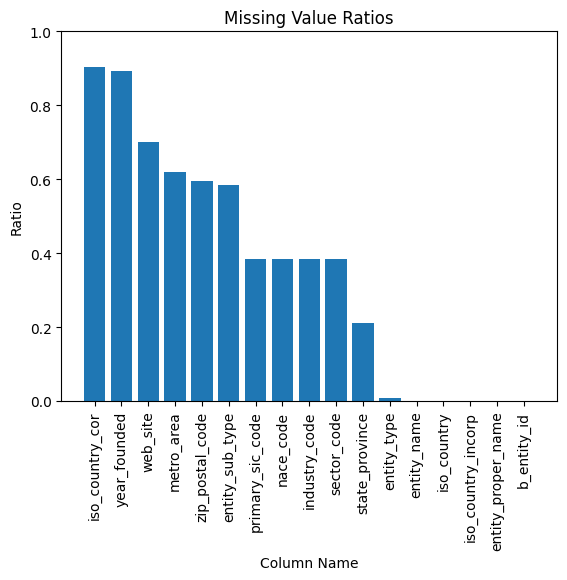

In [ ]:
plot_ratios(ratios_df)

In [ ]:
## clean the data

finComp_data_clean = finComp_data[finComp_all_cols].astype(str)

# clean the procurement company data
for i in finComp_all_cols:
  if i != 'b_entity_id':
    finComp_data_clean[i] = clean(finComp_data_clean[i], lowercase=True,
                             strip_accents='unicode')
  else:
    finComp_data_clean[i] = clean(finComp_data_clean[i], lowercase=True,
                                  replace_by_none='-')

In [ ]:
## lets add a zipcode flag and see if we can utilize that for matching across dfs

finComp_data_clean['zipcode_flag'] = finComp_data_clean['zip_postal_code'] .\
                                        apply(lambda x: 1 if x != 'nan' else 0)

In [ ]:
finComp_data_clean

,b_entity_id,entity_name,entity_proper_name,primary_sic_code,industry_code,sector_code,iso_country,metro_area,state_province,zip_postal_code,web_site,entity_type,entity_sub_type,year_founded,iso_country_incorp,iso_country_cor,nace_code,zipcode_flag
FC_record,,,,,,,,,,,,,,,,,,
0,000bfge,lotsoff corp,lotoff corp,53310,35200,35000,us,san antoniotx metro,tx,78209,nan,pvt,cp,19750,us,us,4719,1
1,000p08e,laserscope inc,laserscope inc,38450,23250,23000,us,san franciscoca metro,ca,95134,httpwwwlaserscopecom,sub,cp,19820,us,ie,266,1
2,000jf6e,longwen group corp,longwen group corp,67990,33200,33000,us,phoenixaz metro,az,85258,nan,pub,cp,19800,us,us,6499,1
4,000ny7e,la gear inc,la gear inc,51390,32550,32500,us,los angelesca metro,ca,90049,httpwwwlagearcom,sub,cp,19790,us,us,4642,1
5,000ny8e,la quinta inns inc,la quinta inns inc,70110,34400,34000,us,san antoniotx metro,tx,78299,nan,ext,cp,19680,us,us,551,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196449,0hpwhge,lvs iii spe iv lp,lvs iii spe iv lp,nan,nan,nan,us,nan,ca,nan,nan,sub,nan,nan,us,nan,nan,0
196452,0hpwhle,lvs iii spe xvi lp,lvs iii spe xvi lp,nan,nan,nan,us,nan,ca,nan,nan,sub,nan,nan,us,nan,nan,0
196470,0hpx85e,loral holdings corp,loral holdings corp,nan,nan,nan,us,nan,de,nan,nan,sub,nan,nan,us,nan,nan,0


In [ ]:
finComp_data_clean['primary_sic_code'].str.len().value_counts()

5    41531
3    26078
4      174
Name: primary_sic_code, dtype: int64

In [ ]:
finComp_data_clean.loc[finComp_data_clean['zip_postal_code'].str.len() > 5]

,b_entity_id,entity_name,entity_proper_name,primary_sic_code,industry_code,sector_code,iso_country,metro_area,state_province,zip_postal_code,web_site,entity_type,entity_sub_type,year_founded,iso_country_incorp,iso_country_cor,nace_code,zipcode_flag
FC_record,,,,,,,,,,,,,,,,,,
2770,007kxve,little women tour llc,little women tour llc,nan,nan,nan,us,baltimorewash dc metro,md,208863002,nan,pvt,cp,nan,us,nan,nan,1
4611,0074yze,loews cineplex us callco llc,loews cineplex us callco llc,78320,34300,34000,us,new york cityny metro,ny,100022,nan,sub,cp,nan,us,nan,5914,1
20511,05pm9ne,lusa inc,lusa inc,30890,12500,12000,us,nan,ma,02019 1406,nan,sub,cp,nan,us,nan,2229,1
22715,05tcxse,ll jiroch co,ll jiroch co,51410,32600,32500,us,detroitmi metro,mi,495032,httpwwwlljirochcom,sub,cp,nan,us,nan,4639,1
26800,061fmxe,lasmo america ltd,lasmo america ltd,nan,nan,nan,us,nan,tx,770461203,nan,sub,cp,nan,us,it,nan,1
27120,0625dre,lexington instruments corp,lexington instruments corp,38410,23250,23000,us,bostonma metro,ma,024532453,nan,pvt,cp,nan,us,us,325,1
34092,06pdlqe,lippman mahfouz martin,lippman mahfouz martin,nan,nan,nan,us,new orleansla metro,la,703801,nan,pvt,cp,nan,us,nan,nan,1
36107,06vypde,loyes pharmacy inc,loyes pharmacy inc,nan,nan,nan,us,dallasft worth tx metro,la,710550,nan,pvt,cp,nan,us,nan,nan,1
42170,07gtlqe,law offices of charles w barkley,law offices of charles w barkley,81110,32050,32000,us,charlottenc metro,nc,282110,nan,pvt,nan,nan,us,nan,691,1


In [ ]:
## for this we'll make the assumption that the zipcode values longer than five still have a piece of the extra four digits

finComp_data_clean['zip_postal_code'] = finComp_data_clean['zip_postal_code'] .\
                                                        apply(lambda x: x[:5])

In [ ]:
## add leading zeros in the necessary columns

finComp_data_clean['primary_sic_code'] = finComp_data_clean['primary_sic_code'].\
                                  apply('{:0>5}'.format)  # longest string is 5
finComp_data_clean['zip_postal_code'] = finComp_data_clean['zip_postal_code'] .\
                                  apply('{:0>5}'.format)  # longest string is 5
finComp_data_clean['industry_code'] = finComp_data_clean['industry_code'] .\
                            apply('{:0>5}'.format)  # longest string is 5
finComp_data_clean['sector_code'] = finComp_data_clean['sector_code'] .\
                                  apply('{:0>5}'.format)  # longest string is 5

In [ ]:
finComp_data_clean.loc[finComp_data_clean['zip_postal_code'] != 'nan']

,b_entity_id,entity_name,entity_proper_name,primary_sic_code,industry_code,sector_code,iso_country,metro_area,state_province,zip_postal_code,web_site,entity_type,entity_sub_type,year_founded,iso_country_incorp,iso_country_cor,nace_code,zipcode_flag
FC_record,,,,,,,,,,,,,,,,,,
0,000bfge,lotsoff corp,lotoff corp,53310,35200,35000,us,san antoniotx metro,tx,78209,nan,pvt,cp,19750,us,us,4719,1
1,000p08e,laserscope inc,laserscope inc,38450,23250,23000,us,san franciscoca metro,ca,95134,httpwwwlaserscopecom,sub,cp,19820,us,ie,266,1
2,000jf6e,longwen group corp,longwen group corp,67990,33200,33000,us,phoenixaz metro,az,85258,nan,pub,cp,19800,us,us,6499,1
4,000ny7e,la gear inc,la gear inc,51390,32550,32500,us,los angelesca metro,ca,90049,httpwwwlagearcom,sub,cp,19790,us,us,4642,1
5,000ny8e,la quinta inns inc,la quinta inns inc,70110,34400,34000,us,san antoniotx metro,tx,78299,nan,ext,cp,19680,us,us,551,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196449,0hpwhge,lvs iii spe iv lp,lvs iii spe iv lp,00nan,00nan,00nan,us,nan,ca,00nan,nan,sub,nan,nan,us,nan,nan,0
196452,0hpwhle,lvs iii spe xvi lp,lvs iii spe xvi lp,00nan,00nan,00nan,us,nan,ca,00nan,nan,sub,nan,nan,us,nan,nan,0
196470,0hpx85e,loral holdings corp,loral holdings corp,00nan,00nan,00nan,us,nan,de,00nan,nan,sub,nan,nan,us,nan,nan,0


In [ ]:
finComp_data_clean['entity_type_2'] = finComp_data_clean['entity_name'] .\
                                    str.rsplit(' ', n=1, expand=True)[1]

In [ ]:
finComp_data_clean['entity_type_2'].value_counts().nlargest(10)

inc      19940
llc      13987
lp        3301
corp      2677
co        1803
fund      1237
ltd        944
pc         567
trust      480
group      377
Name: entity_type_2, dtype: int64

In [ ]:
test = finComp_data_clean
test

,b_entity_id,entity_name,entity_proper_name,primary_sic_code,industry_code,sector_code,iso_country,metro_area,state_province,zip_postal_code,web_site,entity_type,entity_sub_type,year_founded,iso_country_incorp,iso_country_cor,nace_code,zipcode_flag,entity_type_2
FC_record,,,,,,,,,,,,,,,,,,,
0,000bfge,lotsoff corp,lotoff corp,53310,35200,35000,us,san antoniotx metro,tx,78209,nan,pvt,cp,19750,us,us,4719,1,corp
1,000p08e,laserscope inc,laserscope inc,38450,23250,23000,us,san franciscoca metro,ca,95134,httpwwwlaserscopecom,sub,cp,19820,us,ie,266,1,inc
2,000jf6e,longwen group corp,longwen group corp,67990,33200,33000,us,phoenixaz metro,az,85258,nan,pub,cp,19800,us,us,6499,1,corp
4,000ny7e,la gear inc,la gear inc,51390,32550,32500,us,los angelesca metro,ca,90049,httpwwwlagearcom,sub,cp,19790,us,us,4642,1,inc
5,000ny8e,la quinta inns inc,la quinta inns inc,70110,34400,34000,us,san antoniotx metro,tx,78299,nan,ext,cp,19680,us,us,551,1,inc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196449,0hpwhge,lvs iii spe iv lp,lvs iii spe iv lp,00nan,00nan,00nan,us,nan,ca,00nan,nan,sub,nan,nan,us,nan,nan,0,lp
196452,0hpwhle,lvs iii spe xvi lp,lvs iii spe xvi lp,00nan,00nan,00nan,us,nan,ca,00nan,nan,sub,nan,nan,us,nan,nan,0,lp
196470,0hpx85e,loral holdings corp,loral holdings corp,00nan,00nan,00nan,us,nan,de,00nan,nan,sub,nan,nan,us,nan,nan,0,corp


In [ ]:
finComp_data_clean['entity_sub_type'].value_counts()

nan    39685
cp     26821
vc       338
gv       288
ia       170
hf       147
fu       129
br        54
pb        49
in        46
re        16
ml         6
cu         6
pf         5
fh         5
fy         4
mf         4
fo         3
fs         2
ff         2
sb         2
bm         1
Name: entity_sub_type, dtype: int64

#### De-Duplicate

In [ ]:
indexer= rl.Index()
indexer.block('b_entity_id')
candidate_links = indexer.index(finComp_data_clean)
len(candidate_links)

0

Since there are 0 duplicate records let's move on to the nest step.

### Location Data

In [ ]:
finLoc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84882 entries, 0 to 84881
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   address_id            84882 non-null  int64  
 1   b_entity_id           84882 non-null  object 
 2   location_city         79156 non-null  object 
 3   state_province        70194 non-null  object 
 4   location_postal_code  68252 non-null  object 
 5   city_state_zip        79156 non-null  object 
 6   location_street1      72296 non-null  object 
 7   location_street2      29849 non-null  object 
 8   location_street3      6512 non-null   object 
 9   iso_country           84870 non-null  object 
 10  tele_country          84725 non-null  float64
 11  tele_area             39708 non-null  object 
 12  tele                  41806 non-null  object 
 13  tele_full             41806 non-null  object 
 14  fax_country           84565 non-null  float64
 15  fax_area           

In [ ]:
## set index

finLoc_data.index.name = 'FL_record'

In [ ]:
finLoc_data = finLoc_data.loc[finLoc_data['iso_country'] == 'US']

In [ ]:
finLoc_data.head()

,address_id,b_entity_id,location_city,state_province,location_postal_code,city_state_zip,location_street1,location_street2,location_street3,iso_country,tele_country,tele_area,tele,tele_full,fax_country,fax_area,fax,fax_full,hq
FL_record,,,,,,,,,,,,,,,,,,,
5,100033,05RHBM-E,Warren,OH,NaN,"Warren, OH",NaN,NaN,NaN,US,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1
6,100042,05PKBB-E,Spokane,WA,99216,"Spokane, WA 99216",12310 East Mirabeau Parkway,NaN,NaN,US,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1
11,1000609,07YRNR-E,Augusta,GA,30901,"Augusta, GA 30901",1296 Broad Street,NaN,NaN,US,1.0,706,724.5756,1.706.724.5756,1.0,706.0,724.3955,1.706.724.3955,1
16,1000705,0BGVWF-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1
21,1001046,0BGXC0-E,Bethesda,MD,20814.6059,"Bethesda, MD 20814.6059",7801 Norfolk Avenue,Suite 102,NaN,US,1.0,301,913.0204,1.301.913.0204,1.0,301.0,NaN,NaN,1


In [ ]:
## convert all columns to str types

finLoc_data_clean = finLoc_data.astype(str)

finLoc_data_clean['location_postal_code'] = finLoc_data_clean['location_postal_code'].str.split('-', expand=True)[0]
finLoc_data_clean['location_postal_code'] = finLoc_data_clean['location_postal_code'].str.split('.', expand=True)[0]

In [ ]:
finLoc_data_clean.head()

,address_id,b_entity_id,location_city,state_province,location_postal_code,city_state_zip,location_street1,location_street2,location_street3,iso_country,tele_country,tele_area,tele,tele_full,fax_country,fax_area,fax,fax_full,hq
FL_record,,,,,,,,,,,,,,,,,,,
5,100033,05RHBM-E,Warren,OH,nan,"Warren, OH",nan,nan,nan,US,1.0,nan,nan,nan,1.0,nan,nan,nan,1
6,100042,05PKBB-E,Spokane,WA,99216,"Spokane, WA 99216",12310 East Mirabeau Parkway,nan,nan,US,1.0,nan,nan,nan,1.0,nan,nan,nan,1
11,1000609,07YRNR-E,Augusta,GA,30901,"Augusta, GA 30901",1296 Broad Street,nan,nan,US,1.0,706,724.5756,1.706.724.5756,1.0,706.0,724.3955,1.706.724.3955,1
16,1000705,0BGVWF-E,nan,nan,nan,nan,nan,nan,nan,US,1.0,nan,nan,nan,1.0,nan,nan,nan,1
21,1001046,0BGXC0-E,Bethesda,MD,20814,"Bethesda, MD 20814.6059",7801 Norfolk Avenue,Suite 102,nan,US,1.0,301,913.0204,1.301.913.0204,1.0,301.0,nan,nan,1


In [ ]:
## clean the data

finLoc_cols = finLoc_data_clean.columns.tolist()

for i in finLoc_cols:
  if i != 'b_entity_id':
    finLoc_data_clean[i] = clean(finLoc_data_clean[i], lowercase=True,
                             strip_accents='unicode')
  else:
    finLoc_data_clean[i] = clean(finLoc_data_clean[i], lowercase=True,
                                  replace_by_none='-')


In [ ]:
## standardize zip and area code length

finLoc_data_clean['location_postal_code'] = finLoc_data_clean['location_postal_code'].apply('{:0>5}'.format)

In [ ]:
## analyze the amount of null values in each column and the ratio of null to total rows

ratios = {}

for i in finLoc_cols:
  missing = (finLoc_data_clean[i] == '').sum() + (finLoc_data_clean[i] == 'nan').\
                                    sum() + (finLoc_data_clean[i].isna()).sum()
  numRows = finLoc_data_clean.shape[0]

  ratio = missing / numRows

  ratios[i] = ratio

ratios_df = pd.DataFrame.from_dict(ratios, orient='index', columns=['ratio']) .\
                                      sort_values(by='ratio', ascending=False)
ratios_df['column_name'] = ratios_df.index
ratios_df.reset_index(drop=True, inplace=True)

ratios_df

,ratio,column_name
0,0.986480,location_street3
1,0.686039,fax_full
2,0.686039,fax
3,0.630215,location_street2
4,0.534860,fax_area
5,0.469453,tele
6,0.469453,tele_full
7,0.466441,tele_area
8,0.105007,location_street1
9,0.042099,location_city


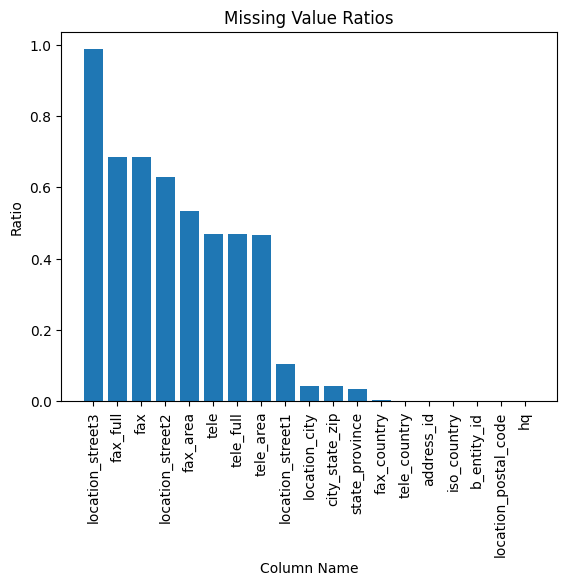

In [ ]:
plot_ratios(ratios_df)

In [ ]:
## drop the columns with excessive missing values and cols we wont need for this join
finLoc_data_clean = finLoc_data_clean.drop(['location_street3', 'fax',
                                            'fax_full', 'location_street2',
                                            'fax_area', 'tele_full'], axis=1)

In [ ]:
finLoc_data_clean

,address_id,b_entity_id,location_city,state_province,location_postal_code,city_state_zip,location_street1,iso_country,tele_country,tele_area,tele,fax_country,hq
FL_record,,,,,,,,,,,,,
5,100033,05rhbme,warren,oh,00nan,warren oh,nan,us,10,nan,nan,10,1
6,100042,05pkbbe,spokane,wa,99216,spokane wa 99216,12310 east mirabeau parkway,us,10,nan,nan,10,1
11,1000609,07yrnre,augusta,ga,30901,augusta ga 30901,1296 broad street,us,10,706,7245756,10,1
16,1000705,0bgvwfe,nan,nan,00nan,nan,nan,us,10,nan,nan,10,1
21,1001046,0bgxc0e,bethesda,md,20814,bethesda md 208146059,7801 norfolk avenue,us,10,301,9130204,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84866,999866,07zhs5e,ceres,ca,95307,ceres ca 95307,5528 faith home road,us,10,209,5311454,10,1
84872,999908,0bgr9fe,pasadena,ca,91107,pasadena ca 91107,253 north san gabriel boulevard,us,10,nan,nan,10,1
84874,999923,0bg7cle,concord,ca,94520,concord ca 94520,1850 bates avenue,us,10,925,6766002,10,1


In [ ]:
finLoc_data_clean['tele_area'].value_counts()

nan     13628
212       514
800       302
2120      219
8000      192
        ...  
220         1
275         1
123         1
736         1
874         1
Name: tele_area, Length: 614, dtype: int64

#### De-Duplicate the Set

In [ ]:
indexer = rl.Index()
indexer.block('b_entity_id')
candidate_links = indexer.index(finLoc_data_clean)
len(candidate_links)

1456

In [ ]:
## since we have 1456 potential duplicates in the set we'll have to continue with the de duplication

compare_dupes = rl.Compare()

compare_dupes.exact('address_id', 'address_id', label='address_id')
compare_dupes.exact('b_entity_id', 'b_entity_id', label='b_entity_id')
compare_dupes.string('location_street1', 'location_street1', method='jarowinkler',
                     threshold=0.85, label='location_street1')
compare_dupes.exact('location_postal_code', 'location_postal_code',
                    label='location_zip_code')
compare_dupes.exact('tele_area', 'tele_area', label='tele_area')

dupe_features = compare_dupes.compute(candidate_links, finLoc_data_clean)

In [ ]:
dupe_features

,,address_id,b_entity_id,location_street1,location_zip_code,tele_area
FL_record_1,FL_record_2,,,,,
115,113,0,1,0.0,0,0
15457,196,0,1,1.0,1,0
47868,306,0,1,0.0,0,0
50478,317,0,1,0.0,0,0
69017,323,0,1,0.0,0,0
...,...,...,...,...,...,...
83874,83873,0,1,0.0,0,1
84027,84025,0,1,0.0,0,0
84182,84181,0,1,0.0,0,0


In [ ]:
dupe_features.sum(axis=1).value_counts().sort_index(ascending=False)

4.0     70
3.0    142
2.0    265
1.0    979
dtype: int64

In [ ]:
## add column to view the total columns with matching data

potential_dupes = dupe_features[dupe_features.sum(axis=1) > 1].reset_index()
potential_dupes['Score'] = potential_dupes.loc[:, 'address_id':'tele_area'] .\
                                                                sum(axis=1)

In [ ]:
potential_dupes

,FL_record_1,FL_record_2,address_id,b_entity_id,location_street1,location_zip_code,tele_area,Score
0,15457,196,0,1,1.0,1,0,3.0
1,661,660,0,1,0.0,0,1,2.0
2,64394,955,0,1,0.0,1,0,2.0
3,13247,1323,0,1,0.0,0,1,2.0
4,44494,1946,0,1,1.0,1,0,3.0
...,...,...,...,...,...,...,...,...
472,82359,82357,0,1,1.0,1,1,4.0
473,83465,83464,0,1,0.0,0,1,2.0
474,83816,83814,0,1,0.0,0,1,2.0
475,83874,83873,0,1,0.0,0,1,2.0


In [ ]:
predicted_not_dupes = potential_dupes.loc[potential_dupes['Score'] > 2]

In [ ]:
predicted_not_dupes = predicted_not_dupes .\
                      rename(columns={'FL_record_1': 'FL_record'})

In [ ]:
FL_dup = finLoc_data_clean
FL_dup = FL_dup.drop(['address_id', 'city_state_zip',
                      'tele_country', 'hq'], axis=1)

In [ ]:
finLoc_data_clean_2 = predicted_not_dupes.merge(FL_dup, how='outer',
                                                on='FL_record')

In [ ]:
finLoc_data_clean_2.shape[0]

29222

In [ ]:
finLoc_data_clean_2.columns

Index(['FL_record', 'FL_record_2', 'address_id', 'b_entity_id_x',
       'location_street1_x', 'location_zip_code', 'tele_area_x', 'Score',
       'b_entity_id_y', 'location_city', 'state_province',
       'location_postal_code', 'location_street1_y', 'iso_country',
       'tele_area_y', 'tele', 'fax_country'],
      dtype='object')

In [ ]:
## Finish by keeping only the columns we'll need for linkage with the proc data
finLoc_data_clean_2 = finLoc_data_clean_2.drop(['FL_record', 'FL_record_2',
                                                'address_id', 'b_entity_id_x',
                                                'location_street1_x',
                                                'location_zip_code', 'tele_area_x',
                                                'Score', 'fax_country'], axis=1)

In [ ]:
finLoc_data_clean_2.index.name = 'FL_record'
finLoc_data_clean_2.head(2)

,b_entity_id_y,location_city,state_province,location_postal_code,location_street1_y,iso_country,tele_area_y,tele
FL_record,,,,,,,,
0,00d0zbe,houston,tx,77079,14520 memorial drive,us,713,8288305
1,05pmx6e,new york,ny,10017,230 park avenue,us,2120,3098100


### Join the Finance Data

In [ ]:
print(finComp_data_clean.columns)
print(finLoc_data_clean_2.columns)

Index(['b_entity_id', 'entity_name', 'entity_proper_name', 'primary_sic_code',
       'industry_code', 'sector_code', 'iso_country', 'metro_area',
       'state_province', 'zip_postal_code', 'web_site', 'entity_type',
       'entity_sub_type', 'year_founded', 'iso_country_incorp',
       'iso_country_cor', 'nace_code', 'zipcode_flag', 'entity_type_2'],
      dtype='object')
Index(['b_entity_id_y', 'location_city', 'state_province',
       'location_postal_code', 'location_street1_y', 'iso_country',
       'tele_area_y', 'tele'],
      dtype='object')


In [ ]:
indexer = rl.Index()
indexer.block(left_on='b_entity_id', right_on='b_entity_id_y')
candidate_links = indexer.index(finComp_data_clean, finLoc_data_clean_2)
len(candidate_links)

29194

In [ ]:
## compute the link scores
compare_cl = rl.Compare()

compare_cl.exact('b_entity_id', 'b_entity_id_y', label='b_entity_id')
compare_cl.string('metro_area', 'location_city', method='jarowinkler',
                  threshold=0.85, label='location_city')
compare_cl.exact('state_province', 'state_province', label='state')
compare_cl.exact('zip_postal_code', 'location_postal_code', label='zipcode')

features = compare_cl.compute(candidate_links, finComp_data_clean, finLoc_data_clean_2)

In [ ]:
features.sum(axis=1).value_counts().sort_index(ascending=False)

4.0     8833
3.0    19627
2.0      314
1.0      420
dtype: int64

In [ ]:
features

b_entity_id  location_city  state  zipcode
FC_record FL_record                                            
0         21066                1            1.0      1        1
1         5036                 1            0.0      1        1
2         11566                1            0.0      0        0
          14042                1            0.0      0        0
          16564                1            0.0      1        1
...                          ...            ...    ...      ...
194422    19546                1            0.0      1        1
194429    19547                1            0.0      1        1
195779    19560                1            1.0      1        1
195781    19558                1            0.0      1        1
196487    19563                1            0.0      1        1

[29194 rows x 4 columns]

In [ ]:
potential_matches = features[features.sum(axis=1) > 2].reset_index()
potential_matches['Score'] = potential_matches.loc[:, 'b_entity_id':'zipcode'].\
                                                                    sum(axis=1)

In [ ]:
potential_matches.head(3)

,FC_record,FL_record,b_entity_id,location_city,state,zipcode,Score
0,0,21066,1,1.0,1,1,4.0
1,1,5036,1,0.0,1,1,3.0
2,2,16564,1,0.0,1,1,3.0


In [ ]:
## merge the data together

financeDf = potential_matches

# make sub dfs for the columns we want to include
fcMerge = finComp_data_clean
fcMerge = fcMerge.drop(['primary_sic_code', 'industry_code', 'sector_code',
                        'web_site', 'entity_type', 'entity_sub_type', 'year_founded',
                        'iso_country_incorp', 'iso_country_cor', 'nace_code',
                        'zipcode_flag'], axis=1)

flMerge = finLoc_data_clean_2
# flMerge = flMerge.drop(['geo_id', 'zipcode', 'is_primary', 'county_fips',
#                         'state_fips', 'timezone', 'daylight_saving',
#                         'region', 'division', 'country', 'continent',
#                         'area_code_1', 'area_code_2', 'area_code_3'], axis=1)

## no need to drop columns from flmerge

In [ ]:
flMerge.columns

Index(['b_entity_id_y', 'location_city', 'state_province',
       'location_postal_code', 'location_street1_y', 'iso_country',
       'tele_area_y', 'tele'],
      dtype='object')

In [ ]:
financeDf = potential_matches.merge(fcMerge, on='FC_record', how='inner')

In [ ]:
financeDf = financeDf.merge(flMerge, on='FL_record', how='inner')

In [ ]:
financeDf = financeDf.drop(['FC_record', 'FL_record', 'b_entity_id_x',
                            'location_city_x', 'state', 'zipcode', 'Score',
                            'b_entity_id_y_y', 'metro_area',
                            'state_province_x', 'iso_country_x', 'iso_country_y',
                            'zip_postal_code'], axis=1)
financeDf.index.name = 'fRecord'

## Record Linkage Between the Two Data Sets

In [ ]:
procurementDf.head(3)

,vendor_id,geo_id_y,name,address,country,zipcode_y,area_code,rest_of_phone,state,city,city_display,county
pRecord,,,,,,,,,,,,
0,285924451,008278,lake image systems inc,205 summit point dr 2,us,14467,585,3213630,ny,henrietta,henrietta,monroe
1,173865819,010736,lafayette college,200 high st,us,18042,610,3305070,pa,easton,easton,northampton
2,052135625,011807,laurel bridge software inc,160 e main street,us,19711,302,4538947,de,newark,newark,new castle


In [ ]:
financeDf.head(3)

,b_entity_id_y_x,entity_name,entity_proper_name,entity_type_2,location_city_y,state_province_y,location_postal_code,location_street1_y,tele_area_y,tele
fRecord,,,,,,,,,,
0,000bfge,lotsoff corp,lotoff corp,corp,san antonio,tx,78209,1201 austin highway,210,8059300
1,000p08e,laserscope inc,laserscope inc,inc,san jose,ca,95134,3070 orchard drive,408,9430636
2,000jf6e,longwen group corp,longwen group corp,corp,scottsdale,az,85258,7702 east doubletree ranch road,4800,6074393


1. Index the data

In [ ]:
indexer = rl.Index()
indexer.sortedneighbourhood(left_on='name', right_on='entity_name')
candidate_links = indexer.index(procurementDf, financeDf)
len(candidate_links)

8464

2. Compare the Candidate Links

In [ ]:
## compute the link scores

compare_cl = rl.Compare()

compare_cl.string('name', 'entity_name', method='jarowinkler', threshold=0.85,
                  label='name_entity_name')
compare_cl.string('address', 'location_street1_y', method='jarowinkler',
                  threshold=0.85, label='addres_location_street1')
compare_cl.exact('zipcode_y', 'location_postal_code', label='zipcode')
compare_cl.exact('area_code', 'tele_area_y', label='area_tele_area')
compare_cl.string('rest_of_phone', 'tele', threshold=.85, label='rest_of_tele')
compare_cl.exact('state', 'state_province_y', label='state')
compare_cl.string('city_display', 'location_city_y', threshold=.85,
                  label='city_location_city')

features = compare_cl.compute(candidate_links, procurementDf, financeDf)

a. Method #1

In [ ]:
features

,,name_entity_name,addres_location_street1,zipcode,area_tele_area,rest_of_tele,state,city_location_city
pRecord,fRecord,,,,,,,
0,13821,0.0,0.0,0,0,0.0,1,0.0
1,369,0.0,0.0,0,0,0.0,0,0.0
2,1784,0.0,0.0,0,0,0.0,0,0.0
3,1784,0.0,0.0,0,0,0.0,0,0.0
4,22046,0.0,0.0,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
5042,19603,0.0,0.0,0,0,0.0,0,0.0
5043,8142,1.0,0.0,1,1,1.0,1,1.0
5044,8142,1.0,0.0,1,1,1.0,1,1.0


CLassify the matches using the ECM model

In [ ]:
## use the Record Linkage Toolkit ECM algo

ecm = rl.ECMClassifier(binarize=.85, use_col_names=True)

ecm_fit = ecm.fit_predict(features)

In [ ]:
ecm_predict = ecm.predict(features)
ecm_conf = ecm.prob(features)

In [ ]:
ecm_conf = pd.DataFrame(ecm_conf)
ecm_conf

,,0
pRecord,fRecord,
0,13821,6.421840e-04
1,369,1.375161e-07
2,1784,1.375161e-07
3,1784,1.375161e-07
4,22046,1.375161e-07
...,...,...
5042,19603,1.375161e-07
5043,8142,1.000000e+00
5044,8142,1.000000e+00


In [ ]:
ecm_conf['confidence_of_match'] = ecm_conf[0]

In [ ]:
ecm_conf = ecm_conf.drop(0, axis=1)

In [ ]:
ecm_conf['confidence_of_match'] = ecm_conf['confidence_of_match'].round(4)
ecm_conf = ecm_conf.sort_values(by='confidence_of_match', ascending=False)

In [ ]:
ecm_conf

,,confidence_of_match
pRecord,fRecord,
2701,20152,1.0
3523,11400,1.0
3082,17497,1.0
3078,5924,1.0
3074,3738,1.0
...,...,...
4687,7553,0.0
4686,25704,0.0
4685,25704,0.0


In [ ]:
# reset the index and merge the data sets
ecm_conf = ecm_conf.loc[ecm_conf['confidence_of_match'] > .75].reset_index()

record_links = ecm_conf

procurement_merge = procurementDf['vendor_id']
finance_merge = financeDf['b_entity_id_y_x']

record_links = record_links.merge(procurement_merge, on='pRecord', how='inner')
record_links = record_links.merge(finance_merge, on='fRecord', how='inner')

record_links = record_links.drop(['pRecord', 'fRecord'], axis=1)

In [ ]:
record_links.head()

,confidence_of_match,vendor_id,b_entity_id_y_x
0,1.0,143217898,0dd7w8e
1,1.0,052153194,07qswve
2,1.0,052155545,0cjz2me
3,1.0,177008404,0cjz2me
4,1.0,310439005,06170ne


In [ ]:
## reorder the columns in the df

record_links = record_links[['vendor_id', 'b_entity_id_y_x',
                             'confidence_of_match']]
record_links = record_links.rename(columns={'b_entity_id_y_x': 'b_entity_id'})
record_links = record_links.sort_values(by='confidence_of_match',
                                        ascending=False)

In [ ]:
record_links.reset_index(drop=True, inplace=True)
record_links

,vendor_id,b_entity_id,confidence_of_match
0,143217898,0dd7w8e,1.0000
1,147432424,0hf630e,1.0000
2,051543174,07jkcye,1.0000
3,051543174,064swse,1.0000
4,136172110,07r74se,1.0000
...,...,...,...
749,283757913,07vjrwe,0.8119
750,052166472,0cddrne,0.8119
751,143227093,07vjrwe,0.8119
752,328202220,077rqre,0.8119


In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
record_links.to_csv('record_links.csv')
!cp record_links.csv "drive/My Drive/"